In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from scipy.special import expit
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Simulation parameters
MONTE_CARLO_ROUNDS = 2000

# Plot display parameters
ELO_SPACING = 20

In [3]:
# An array mapping index in leg standings to points received
place_to_points = [13, 10] + [7]*2 + [4]*4 + [2]*4 + [0]*20

In [4]:
name_to_rating = {
    "Ding Liren": 2799.0,
    "Levon Aronian": 2784.8,
    "Wesley So": 2778.2,
    "Shakhriyar Mamedyarov": 2776.1,
    "Anish Giri": 2771.0,
    "Richard Rapport": 2761.9,
    "Maxime Vachier-Lagrave": 2761.0,
    "Alexander Grischuk": 2758.4,
    "Leinier Dominguez": 2755.8,
    "Hikaru Nakamura": 2750.4,
    "Nikita Vitiugov": 2726.0,
    "Dmitry Andreikin": 2724.0,
    "Andrey Esipenko": 2723.3,
    "Vidit Gujrathi": 2723.1,
    "Pentala Harikrishna": 2716.0,
    "Yu Yangyi": 2713.0,
    "Daniil Dubov": 2711.4,
    "Vladimir Fedoseev": 2704.4,
    "Sam Shankland": 2703.7,
    "Radoslaw Wojtaszek": 2693.6,
    "Alexei Shirov": 2692.6,
    "Alexandr Predke": 2682.0,
    "Grigoriy Oparin": 2674.0,
    "Vincent Keymer": 2655.4,
    "Etienne Bacrot": 2635.0,
    "Amin Tabatabaei": 2623.0,
}
hikaru = "Hikaru Nakamura"


In [5]:
# Probabilities taken from https://chance.amstat.org/2020/09/chess/

prob_draw = lambda rwhite, rblack: expit(
    -1.627 + 0.0006955 * rwhite - 0.004668 * abs(rwhite - rblack)
)
prob_beats = lambda ra, rb: 1 / (1 + 10 ** ((rb - ra) / 400))
prob_win = lambda rwhite, rblack: prob_beats(rwhite, rblack) - prob_draw(rwhite, rblack) / 2

In [6]:
def sim_match(elo1, elo2):
    points = 0

    pdraw1 = prob_draw(elo1, elo2)
    pbeats1 = prob_beats(elo1, elo2)
    pwin1 = pbeats1 - pdraw1 / 2

    rand = random.random()
    if rand <= pwin1:
        points += 1
    elif rand > pwin1 + pdraw1:
        points -= 1

    pdraw2 = prob_draw(elo2, elo1)
    pbeats2 = prob_beats(elo2, elo1)
    pwin2 = pbeats2 - pdraw2 / 2

    rand = random.random()
    if rand <= pwin2:
        points -= 1
    elif rand > pwin2 + pdraw2:
        points += 1

    return points


def sim_group(inds, elos):
    n = len(inds)
    points = [0] * n
    for i in range(n):
        for j in range(i + 1, n):
            res = sim_match(elos[inds[i]], elos[inds[j]])
            points[i] += res
            points[j] -= res
    inds_rankings = list(sorted(range(n), key=lambda i: points[i], reverse=True))
    tiebreak = int(points[inds_rankings[0]] != points[inds_rankings[1]])
    while tiebreak == 0:
        ind0, ind1 = inds_rankings[0], inds_rankings[1]
        tiebreak = sim_match(elos[inds[ind0]], elos[inds[ind1]])
        if tiebreak < 0:
            inds_rankings[0], inds_rankings[1] = inds_rankings[1], inds_rankings[0]
    return [inds[i] for i in inds_rankings]


def sim_leg(elos):
    n = len(elos)

    rand_inds = np.array(range(n))
    np.random.shuffle(rand_inds)
    groups = [list(g) for g in np.split(rand_inds, 4)]

    group_results = [sim_group(group, elos) for group in groups]

    rev_standings = []
    for group_place in range(3, 0, -1):
        for group_res in group_results:
            rev_standings.append(group_res[group_place])

    semis = [group_res[0] for group_res in group_results]
    semi1_res = sim_group(semis[:2], elos)
    semi2_res = sim_group(semis[2:], elos)
    rev_standings.append(semi1_res[1])
    rev_standings.append(semi2_res[1])
    finals = [semi1_res[0], semi2_res[0]]
    f_res = sim_group(finals, elos)
    rev_standings.append(f_res[1])
    rev_standings.append(f_res[0])

    leg_points = [0] * n
    for i, player in enumerate(reversed(rev_standings)):
        leg_points[player] = place_to_points[i]

    return leg_points


In [7]:
grand_prix_page = requests.get("https://www.chess.com/article/view/fide-grand-prix-2022")
grand_prix_soup = BeautifulSoup(grand_prix_page.text, 'lxml')

In [8]:
# Leg 1

leg1_players_soup = grand_prix_soup.select(".standings_table")[2]
headers = []
for h in leg1_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg1_players_df = pd.DataFrame(columns = headers)
for row in leg1_players_soup.find_all("tr")[1:]:
    row_data = row.find_all("td")
    row_series = pd.Series([i.text for i in row_data], index = headers)
    leg1_players_df = leg1_players_df.append(row_series, ignore_index=True)
leg1_players_df = leg1_players_df.drop(["Fed"], axis=1)
leg1_players_df["Player"] = leg1_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg1_players_df["Rating"] = leg1_players_df["Player"].apply(lambda n: name_to_rating[n])

leg1_players_df["Leg 1 Points"] = pd.Series([4, 10, 2, 7, 7, 13, 4, 2, 3, 3, 2, 0, 4, 0, 0, 0])

leg1_players_df


,Player,Rating,Leg 1 Points
0,Wesley So,2778.2,4
1,Levon Aronian,2784.8,10
2,Alexander Grischuk,2758.4,2
3,Richard Rapport,2761.9,7
4,Leinier Dominguez,2755.8,7
5,Hikaru Nakamura,2750.4,13
6,Andrey Esipenko,2723.3,4
7,Pentala Harikrishna,2716.0,2
8,Vidit Gujrathi,2723.1,3
9,Daniil Dubov,2711.4,3


In [9]:
# Leg 2 (simulated)

leg2_players_soup = grand_prix_soup.select(".standings_table")[5]
headers = []
for h in leg2_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg2_players_df = pd.DataFrame(columns = headers)
for row in leg2_players_soup.find_all("tr")[1:]:
    row_data = row.find_all("td")
    row_series = pd.Series([i.text for i in row_data], index = headers)
    leg2_players_df = leg2_players_df.append(row_series, ignore_index=True)
leg2_players_df = leg2_players_df.drop(["Fed"], axis=1)
leg2_players_df["Rating"] = leg2_players_df["Player"].apply(lambda n: name_to_rating[n])

round2_elos = [float(elo) for elo in leg2_players_df["Rating"]]
leg2_players_df["Leg 2 Points"] = pd.Series(sim_leg(round2_elos))

leg2_players_df

,Player,Rating,Leg 2 Points
0,Ding Liren,2799.0,7
1,Anish Giri,2771.0,0
2,Shakhriyar Mamedyarov,2776.1,13
3,Alexander Grischuk,2758.4,4
4,Richard Rapport,2761.9,0
5,Maxime Vachier-Lagrave,2761.0,2
6,Nikita Vitiugov,2726.0,2
7,Pentala Harikrishna,2716.0,10
8,Vidit Gujrathi,2723.1,7
9,Yu Yangyi,2713.0,0


In [10]:
# Leg 3 (simulated)

leg3_players_soup = grand_prix_soup.select(".standings_table")[6]
headers = []
for h in leg3_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg3_players_df = pd.DataFrame(columns = headers)
for row in leg3_players_soup.find_all("tr")[1:]:
    row_data = row.find_all("td")
    row_series = pd.Series([i.text for i in row_data], index = headers)
    leg3_players_df = leg3_players_df.append(row_series, ignore_index=True)
leg3_players_df = leg3_players_df.drop(["Fed"], axis=1)
leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])

round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
leg3_players_df["Leg 3 Points"] = pd.Series(sim_leg(round3_elos))

leg3_players_df

,Player,Rating,Leg 3 Points
0,Anish Giri,2771.0,7
1,Wesley So,2778.2,2
2,Levon Aronian,2784.8,13
3,Shakhriyar Mamedyarov,2776.1,10
4,Maxime Vachier-Lagrave,2761.0,7
5,Leinier Dominguez,2755.8,2
6,Hikaru Nakamura,2750.4,4
7,Nikita Vitiugov,2726.0,4
8,Dmitry Andreikin,2724.0,0
9,Daniil Dubov,2711.4,4


In [11]:
def sim_grand_prix():
    leg2_players_df["Rating"] = leg2_players_df["Player"].apply(lambda n: name_to_rating[n])
    round2_elos = [float(elo) for elo in leg2_players_df["Rating"]]
    leg2_players_df["Leg 2 Points"] = pd.Series(sim_leg(round2_elos))

    leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])
    round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
    leg3_players_df["Leg 3 Points"] = pd.Series(sim_leg(round3_elos))

    leg2_cum_df = pd.merge(leg1_players_df, leg2_players_df, on="Player", how="outer")
    final_df = pd.merge(leg2_cum_df, leg3_players_df, on="Player", how="outer")
    final_df["Rating"] = final_df["Player"].apply(lambda n: name_to_rating[n])
    final_df["Leg 1 Points"] = final_df["Leg 1 Points"].fillna(0)
    final_df["Leg 2 Points"] = final_df["Leg 2 Points"].fillna(0)
    final_df["Leg 3 Points"] = final_df["Leg 3 Points"].fillna(0)
    final_df["Total Points"] = final_df["Leg 1 Points"] + final_df["Leg 2 Points"] + final_df["Leg 3 Points"]
    final_df = final_df[["Player", "Rating", "Leg 1 Points", "Leg 2 Points", "Leg 3 Points", "Total Points"]]
    final_df = final_df.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
    final_df.index = final_df.index + 1
    return final_df

100%|██████████| 11/11 [03:34<00:00, 19.49s/it]


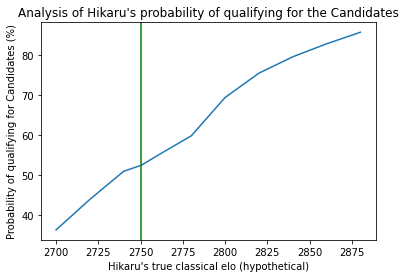

In [12]:
# Probability distribution of Hikaru candidates qualification


def prob_hikaru_qualifies(elo):
    orig_elo = name_to_rating[hikaru]
    name_to_rating[hikaru] = elo
    num_qualifies = 0
    for _ in range(MONTE_CARLO_ROUNDS):
        candidates_rows = sim_grand_prix()[:2]
        num_qualifies += int(any(row["Player"] == hikaru for _, row in candidates_rows.iterrows()))
    name_to_rating[hikaru] = orig_elo
    return num_qualifies / MONTE_CARLO_ROUNDS


hikaru_elo = np.sort(np.append(np.arange(2700, 2900, ELO_SPACING), name_to_rating[hikaru]))
candidates_prob = np.array([prob_hikaru_qualifies(elo) for elo in tqdm(hikaru_elo)])

plt.plot(hikaru_elo, candidates_prob * 100, label="Hikaru's Classical Elo (Hypothetical)")
plt.axvline(x=name_to_rating[hikaru], color="green")
plt.title("Analysis of Hikaru's probability of qualifying for the Candidates")
plt.xlabel("Hikaru's true classical elo (hypothetical)")
plt.ylabel("Probability of qualifying for Candidates (%)")
plt.savefig("hikaru_candidates_prob.png", facecolor="white")
plt.show()

In [13]:
# Average points per player

avg_final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
avg_final.index = avg_final.index + 1

print(f"Average points by player for the simulated FIDE Grand Prix (assuming Hikaru's true elo is {name_to_rating[hikaru]}):")
avg_final

Average points by player for the simulated FIDE Grand Prix (assuming Hikaru's true elo is 2750.4):


,Player,Rating,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,Hikaru Nakamura,2750.4,13.0,0.0000,4.4205,17.4205
2,Levon Aronian,2784.8,10.0,0.0000,6.0085,16.0085
3,Richard Rapport,2761.9,7.0,5.0765,0.0000,12.0765
4,Leinier Dominguez,2755.8,7.0,0.0000,4.8580,11.8580
5,Shakhriyar Mamedyarov,2776.1,0.0,5.6865,5.7010,11.3875
6,Anish Giri,2771.0,0.0,5.5130,5.3120,10.8250
7,Maxime Vachier-Lagrave,2761.0,0.0,4.9165,4.9075,9.8240
8,Wesley So,2778.2,4.0,0.0000,5.7315,9.7315
9,Nikita Vitiugov,2726.0,0.0,3.6725,3.5800,7.2525
10,Alexander Grischuk,2758.4,2.0,4.9170,0.0000,6.9170


In [14]:
# Average points per place

avg_final = sim_grand_prix()

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix()
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.drop(["Player", "Rating"], axis=1)

print(f"Average points by standing position for the simulated FIDE Grand Prix:")
avg_final

Average points by standing position for the simulated FIDE Grand Prix:


,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,7.1000,3.8770,9.9630,20.9400
2,6.4240,4.1315,6.9775,17.5330
3,5.7550,4.4715,5.3460,15.5725
4,4.6010,5.1270,4.3195,14.0475
5,4.0420,5.0490,3.6680,12.7590
6,3.5035,4.5970,3.3985,11.4990
7,3.1490,3.8475,3.4045,10.4010
8,2.7855,3.8010,2.8740,9.4605
9,2.3360,3.5450,2.6530,8.5340
10,1.7955,3.0375,2.8430,7.6760
